## Compute probability of transfer success from delay distributions

To be able to compute the probability of success of a given transfert, we use the arrival delay distribution compared with the next trip departure. To be able to do that, we need delay distributions for each trip arrival to a given station. Whenever we have a clear match, we can use an __cumulative distribution function__ to compute $P(X \leq x)$ :

$${\displaystyle F_{X}(x)=\operatorname {P} (T\leq t)=\sum _{t_{i}\leq t}\operatorname {P} (T=t_{i})=\sum _{t_{i}\leq t}p(t_{i}).}$$

The strategy was to rely entirely on past data we have to compute $p(t_i)$, without the need of building a model which imply making additionnal assumptions. If we have enough data for a given transfer with known trip_id x stop_id, we use the the abovementionned formula to compute each $p(t_i)$ by simply using :

$$p(t_i) = \frac{x_i}{\sum x_i}$$

with $x_i$ being the number of delays at time $t_i$ from SBB historical data from 2018/2019.

### Recover missing data 

As we are using SBB data to compute delays from timetable trip_id, we may encounter problems with the translation between the two datasets (certain trip_id/stop_id have no correspondance datasets!). We may also encounter To recover missing or faulty data, the strategy is the following :

1. If we have more than 100 data points in `real` group, we rely exclusively on its delay distribution to compute probabilities for a given transfer on a `trip_id x stop_id`.

_Note : `real` group corresponds to arrival time with status `geschaetz` or `real`, meaning it comes from actual measurments._

2. If we do not find enough data within `real` group, we use delay distributions in `all` group (contains all delays including `prognose` status), if there is more than 100 data points for a given `trip_id x stop_id`.

3. If `all` group still does not have more than 100 data points, we rely on `recovery tables` to estimate delay distributions. The strategy is the following :
    - We make every combinations of 4 parameters we have, `trip_id`, `stop_id`, the `time` and the `transport_type`, to aggregate delays of similar transfer from historical data. We estimate a hierarchy of recovery tables, to be used in specific order to best recover missing data.
    - We establish a hierarchy for each combination by comparing the probability of success derived from these aggregate against probability made from historical data with defined `trip_id`x`stop_id`. 
    - We use a cascade o

Following this approach, we can find cumulative distribution probabilities for every combination of `trip_id x stop_id` as defined in `stop_times_df`. We will make a table with the same row order so that McRaptor can easily find their indexes. 

In [160]:
import pickle 
import gzip
from itertools import islice
import matplotlib as mlt 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import math

In [161]:
# Functon to take a slice from a dictionnary - head equivalent
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

Load dictionnaries of distributions made in `hdfs_get_distributions.ipynb`

In [162]:
with gzip.open("../data/d_real.pkl.gz", "rb") as input_file:
    d_real = pickle.load(input_file)

with gzip.open("../data/d_all.pkl.gz", "rb") as input_file:
    d_all = pickle.load(input_file)

# display a slice of it
print('len dict_real : ', len(d_real))
print(take(5, d_real.items()))

# display a slice of it
print('len dict_all : ', len(d_all))
print(take(5, d_all.items()))

len dict_real :  16760
[('1.TA.26-20-j19-1.1.R__8503000', array([ 0, 25, 78, 18,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('1.TA.26-20-j19-1.1.R__8503003', array([ 0, 83, 31,  9,  4,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('1.TA.26-20-j19-1.1.R__8503101', array([ 3, 89, 22,  6,  5,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('1.TA.26-20-j19-1.1.R__8503104', array([ 0, 83, 21, 13,  4,  3,  2,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('1.TA.80-173-Y-j19-1.1.H__8502276', array([  0, 315,  61,  17,   2,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0]))]
len dict_all :  240567
[('1.TA.26-161-j

### Recover transfer with low amount of historical data

When we have __enough data__ and __no ambiguity__ about `trip_id` and `stop_id` for a given transfer, then we can compute the probability $P(T \leq t)$ for every $t$ (delay in minute). 

Let's take a __threshold of 100__ sample points (=number of time we could measure a delay in historical data) as a minimum number of points to use this approach. 

_How many keys in our distionnary of distribution have at least this number of samples ?_

In [63]:
def plot_data_points_hist(dico, binwidth = 100):
    list_tot_points = []
    for key in dico:
        distrib = dico[key]
        list_tot_points.append(np.sum(distrib))

    tot_per_key = np.array(list_tot_points)
    n_keys_less_than_binwidth = np.sum(np.array(tot_per_key < binwidth))
    perc_key_to_recover = round(100 * ( n_keys_less_than_binwidth / len(tot_per_key) ), 2)
    plt.figure(figsize = (10,5))
    plt.hist(tot_per_key, bins = range(min(tot_per_key), max(tot_per_key) + binwidth, binwidth))
    plt.title("Total number of data points per trip_id / stop_id key. N keys with less than {0} points: {1} ({2}%)"\
             .format(binwidth, n_keys_less_than_binwidth, perc_key_to_recover))
    plt.xlabel('n data points')
    plt.ylabel('n keys')
    return plt.show()

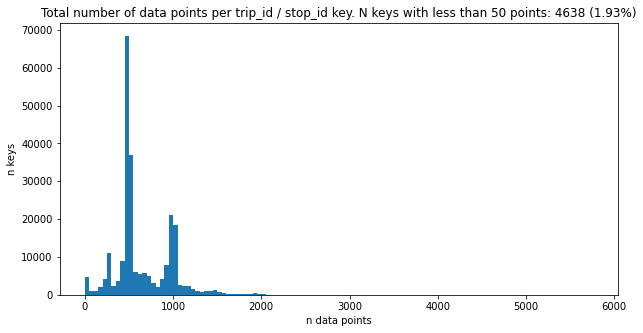

In [64]:
plot_data_points_hist(d_all, binwidth=50)

We see that cases with less than 100 data points in historical data is a rare event.

### Reformat stop_times table

First we need to reformat `stoptimes` table for next steps. Indeed, we need to get time rounded to the hour, correct stop_id format and type, generate `key` column using `trip_id` and `stop_id`, and droping unnecessary columns.

In [66]:
with open("../data/stop_times_df_cyril.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)

# Use stop_id_general as stop_id  
stoptimes['stop_id'] = stoptimes['stop_id_general'].apply(str)

# Set same stoptimes key as distribution dictionnaries d_real/d_all
stoptimes['key'] = stoptimes['trip_id'] + '__' + stoptimes['stop_id']
stoptimes = stoptimes.set_index('key')

# Subset stoptimes 
stoptimes = stoptimes[['trip_id','stop_id', 'route_desc', 'arrival_time', 'departure_time']]

# Iterate over stoptimes to generate rounded hours
list_hours = []
size_stop_times = stoptimes.shape[0]

for x in range(size_stop_times):
    arr_time_hour = pd.to_datetime(stoptimes.iloc[x,:]['arrival_time']).hour
    if math.isnan(arr_time_hour): # if arrival is NaT, use departure time
        arr_time_hour = pd.to_datetime(stoptimes.iloc[x,:]['departure_time']).hour
    list_hours.append(int(arr_time_hour))
    
    # Print % progression 
    if (x % 10000) == 0 :
        print('{}%'.format(round(100*x/size_stop_times,2)), end = ', ')
    
# Add new column with rounded hour
stoptimes['hour'] = list_hours
stoptimes = stoptimes.drop(columns=['arrival_time', 'departure_time'])

# Write this pickle to avoid re-running this above code all the time
with gzip.open("../data/stop_times_wHour.pkl", "wb") as output_file:
    pickle.dump(stoptimes, output_file)         
              

0.0%, 3.84%, 7.68%, 11.52%, 15.36%, 19.2%, 23.04%, 26.88%, 30.72%, 34.55%, 38.39%, 42.23%, 46.07%, 49.91%, 53.75%, 57.59%, 61.43%, 65.27%, 69.11%, 72.95%, 76.79%, 80.63%, 84.47%, 88.31%, 92.15%, 95.98%, 99.82%, 

### Construct recovery tables 

We make every combinations of 4 parameters we have, `trip_id`, `stop_id`, the `time` and the `transport_type`, to aggregate delays of similar transfer from historical data. We estimate a hierarchy of recovery tables, to be used in specific order to best recover missing data. 

_Note : trip_id does not need to be combined with time/transport_type parameters as it already imply a specific time and transport type_

In [163]:
# load formated stop_times tables
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)

# load dictionnary df and stoptimes df
distrib_df = pd.DataFrame(d_all).transpose()
distrib_df_real = pd.DataFrame(d_real).transpose()

stoptimes_df = pd.DataFrame(stoptimes)

# Make join btw. stoptimes and all_distrib
recovery_df = distrib_df.join(stoptimes_df)

We compute a script to make recovery tables. We use data from `real` distribution to make the recovery tables, as they are more likely to be precise.

In [164]:
def make_recovery_tab(recovery_df, list_params):
    list_bins = [x for x in range(32)]
    # Aggregate counts on columns (delay in minute)
    recov_tab = recovery_df.groupby(list_params)[list_bins].apply(lambda x : x.astype(float).sum())
    recov_tab = recov_tab.astype('int')
    return recov_tab

We use our 4 parameters and make every possible combination of them. Note that `trip_id` does not need to be combine with `hour` and `route_desc` (transport type), as it already imply a specific time and transport type.

In [165]:
# Combination of 3 parameters
recov_stop_time_type = make_recovery_tab(recovery_df, ['stop_id','hour','route_desc'])

# Combination of 2 parameters
recov_time_type = make_recovery_tab(recovery_df, ['hour','route_desc'])
recov_stop_type = make_recovery_tab(recovery_df, ['stop_id','route_desc'])
recov_stop_time = make_recovery_tab(recovery_df, ['stop_id','hour'])

# single parameter aggregations
recov_trip_id = make_recovery_tab(recovery_df, ['trip_id'])
recov_time = make_recovery_tab(recovery_df, ['hour'])
recov_stop = make_recovery_tab(recovery_df, ['stop_id'])
recov_type = make_recovery_tab(recovery_df, ['route_desc'])

Overall aggregate distribution (used when everything else fails)

In [166]:
last_chance_distrib = np.array(recovery_df3.sum(axis=0))

### Evaluate precision of recovery tables - establishing hierarchy of _cascade_ 

We used an approach we called “cascades of recovery distributions”, which define how we leverage the parameters at disposal to compute a probability. The idea is to use increasingly aggregated data to optimize the use of historical data given any possible input parameter combination. 

We validated this approach and defined a hierachy of recovery distribution usage by comparison with actual measures from sbb dataset. We use only data with `geschaetz` or `real` status and more than 100 data points to evaluate perfomance of our recovery tables - or in other words distributions coming from aggregated delay distribution using combination of our 4 parameters.

In [167]:
def cdf_distrib(distr_arr):
    """
    Function to compute probability P(X <= x) from a given distribution
    using a Cumulative distribution function
    """
    # get total number of elements 
    N_tot = np.sum(distr_arr)
        
    # make cumulative distribution probabilities
    cdf_distrib = np.empty((len(distr_arr)), dtype=float)
    save_x = 0
    for x in range(len(distrib)):
        cdf_distrib[x] = float(distr_arr[x])/float(N_tot) + float(save_x)/float(N_tot)
        save_x += distr_arr[x]
    
    return cdf_distrib

def residual_in_cdf(cdf1, cdf2):
    """
    Caluclate the average residual error abs(x1 - x2) 
    between probability distributions cdf1 and cdf2 
    """
    res = N_tot = 0.0
    for i in range(len(cdf1)):
        res += abs(float(cdf1[i]) - float(cdf2[i]))
        N_tot += 1.0
    
    return res/N_tot

In [168]:
recovery_df_real = recovery_df.iloc[recovery_df.index.isin(distrib_df_real.index),:]

In [169]:
# declare empty lists
res_recov_stop_time_type, res_recov_stop_time, res_recov_stop_type, res_recov_time_type, \
res_recov_trip_id, res_recov_type, res_recov_stop, res_recov_time, res_fail, \
= ([] for i in range(9))

for index, row in recovery_df_real.iterrows():
    
    distrib_real = np.array(row[0:32])
    trip_id      = row['trip_id']
    stop_id      = str(row['stop_id'])
    transport_type = row['route_desc']
    hour         = row['hour']
    key          = str(trip_id) + '__' + str(stop_id)
    
    # control distrib with trip_id x stop_id 
    cdf_real = cdf_distrib(distrib_real)
    sum_counts = np.sum(distrib_real)
    
    if sum_counts > 100 :
        # recov - stop_time_type
        if (stop_id, hour, transport_type) in recov_stop_time_type.index:
            cdf = cdf_distrib(np.array(recov_stop_time_type.loc[(stop_id, hour, transport_type)]))
            res_recov_stop_time_type.append(residual_in_cdf(cdf, cdf_real))
        
        # recov - time_type
        if (hour, transport_type) in recov_time_type.index:
            cdf = cdf_distrib(np.array(recov_time_type.loc[(hour, transport_type)]))
            res_recov_time_type.append(residual_in_cdf(cdf, cdf_real))

        # recov - stop_time
        if (stop_id, hour) in recov_stop_time.index:
            cdf = cdf_distrib(np.array(recov_stop_time.loc[(stop_id, hour)]))
            res_recov_stop_time.append(residual_in_cdf(cdf, cdf_real))
        
        # recov - stop_type
        if (stop_id, transport_type) in recov_stop_type.index:
            cdf = cdf_distrib(np.array(recov_stop_type.loc[(stop_id, transport_type)]))
            res_recov_stop_type.append(residual_in_cdf(cdf, cdf_real))
        
        # recov - type
        if (transport_type) in recov_type.index:
            cdf = cdf_distrib(np.array(recov_type.loc[(transport_type)]))
            res_recov_type.append(residual_in_cdf(cdf, cdf_real))
        
        # recov - trip_id 
        if (trip_id) in recov_trip_id.index:
            cdf = cdf_distrib(np.array(recov_trip_id.loc[(trip_id)]))
            res_recov_trip_id.append(residual_in_cdf(cdf, cdf_real))
        
        # recov - stop
        if (stop_id) in recov_stop.index:
            cdf = cdf_distrib(np.array(recov_stop.loc[(stop_id)]))
            res_recov_stop.append(residual_in_cdf(cdf, cdf_real))
        
        # recov - time
        if (hour) in recov_time.index:
            cdf = cdf_distrib(np.array(recov_time.loc[(hour)]))
            res_recov_time.append(residual_in_cdf(cdf, cdf_real))
        
        # Evaluate compare with overall_average
        cdf_overall = cdf_distrib(last_chance_distrib)
        res_fail.append(residual_in_cdf(cdf_overall, cdf_real))
        

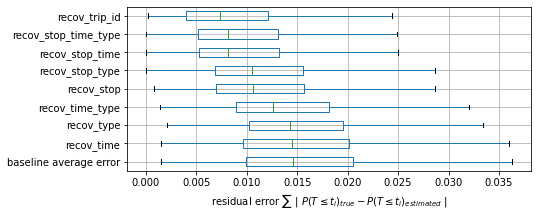

In [217]:
# Assemble residuals to make datasframe 
all_residuals = pd.DataFrame([res_recov_stop_time_type, res_recov_time_type, \
                              res_recov_type, res_recov_trip_id, \
                              res_recov_stop_type, res_recov_stop_time, res_recov_stop, \
                              res_recov_time, res_fail], \
                             index = ['recov_stop_time_type', 'recov_time_type', \
                                      'recov_type', \
                                      'recov_trip_id', 'recov_stop_type',\
                                      'recov_stop_time', \
                                      'recov_stop', 'recov_time', \
                                      'baseline average error']).transpose()
# Sort before plotting
meds = all_residuals.median()
meds.sort_values(ascending=False, inplace=True)
all_residuals = all_residuals[meds.index]

# Boxplot or residuals per recovery tables
plt.figure(figsize = (8,6))
plt.gcf().subplots_adjust(bottom=0.5, left = 0.2)
all_residuals.boxplot(vert=False, showfliers=False)
plt.xlabel('residual error $\sum $ | $P(T \leq t_i)_{true} - P(T \leq t_i)_{estimated} $ |')
plt.savefig("../data/figs/recov_tab_residuals_final.pdf", dpi=300)
plt.show()

The order of importance of recovery tables is therefore :
1. recov_trip_id 
2. recov_stop_time_type
3. recov_stop_time
4. recov_stop
5. recov_time_type
6. recov_type
7. recov_time

### Reconstruct cumulative distribution probabilities from multiple distributions to recover data with few/missing points 

At this point, we have 2 dictionnaries of distributions and multiple recovery dataframes :

 - `d_real` : contains delay distribution for each keys in form `trip_id + __ + stop_id` calculated from delays with status `geschaetz` or `real` in sbb datasets.
 - `d_all` : contains delay distributions for each keys in form `trip_id + __ + stop_id`. No filter was applied on status (contains `geschaetz`, `real` __and__ `prognose` = evaluated delay).
 - `Recovery tables` with different combinations of parameters, are used in the order defined in previous section. Once we find a recovery distribution with more than 100 data points, we __stop the process of recovery__ by seetting the bolean `keep_trying` to `False`.

In [211]:
def try_recovery(recov_df, tup, keep_trying, n_recov, all_distrib):
    """
    Use recovery_df to TRY a recovery if parameters in tuple tup
    exists in target recovery df, and if keep_trying is True
    """
    if keep_trying and tup in recov_df.index:
        distrib = np.array(recov_df.loc[tup])
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_recov += 1
    return n_recov, keep_trying, all_distrib

In [221]:
############### MAKE FINAL DISTRIBUTION TABLE USING RECOVERY TABLES ################

# Load stop_time table, to use its order as a template for our final table 
with open("../data/stop_times_df_cyril.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    

# declare empty variables 
size_stop_times = stoptimes.shape[0]

n_fail = n_real = n_all = n_recov_stop_time_type = n_recov_stop_time =\
n_recov_stop_type = n_recov_time_type = n_recov_stop =\
n_recov_time = n_recov_type = n_recov_trip_id = i = 0

all_distrib, all_transport_type, all_hours, all_keys = \
    ([] for i in range(4))

# Get useful indexes
stop_id_idx = stoptimes.columns.get_loc("stop_id_general")
trip_id_idx = stoptimes.columns.get_loc("trip_id")
transport_type_idx = stoptimes.columns.get_loc("route_desc")

for index, row in stoptimes.iterrows():
    
    trip_id = row[trip_id_idx]
    stop_id = str(row[stop_id_idx])
    transport_type = row[transport_type_idx]
    key = str(trip_id) + '__' + str(stop_id)

    # Compute rounded hour using arrival if possible - recover with departure
    hour = pd.to_datetime(stoptimes.loc[index]['arrival_time']).hour
    if math.isnan(hour): # if arrival is NaT, use departure time
        hour = pd.to_datetime(stoptimes.loc[index]['departure_time']).hour
    
    distrib = np.zeros(31)
    
    # this boolean variable is usefull to STOP the recovery process once a proper
    # distribution with sufficient data points is found 
    keep_trying = True
    
    # 1) try d_real to get distribution from measured delays
    if key in d_real:
        distrib = d_real[key]
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_real += 1
    
    # 2) try d_all to get distribution from measured + estimated delays
    if keep_trying and key in d_all:
        distrib = d_all[key]
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False
            n_all += 1
    
    # 3) try recovery tables in order previously defined
    n_recov_trip_id, keep_trying, all_distrib =\
        try_recovery(recov_trip_id,   (trip_id), keep_trying, n_recov_trip_id, all_distrib)
    n_recov_stop_time_type, keep_trying, all_distrib =\
        try_recovery(recov_stop_time_type, (stop_id, hour, transport_type), \
                 keep_trying, n_recov_stop_time_type, all_distrib)
    n_recov_stop_time, keep_trying, all_distrib =\
        try_recovery(recov_stop_time, (stop_id, hour), keep_trying, n_recov_stop_time, all_distrib)
    n_recov_stop, keep_trying, all_distrib =\
        try_recovery(recov_stop, (stop_id), keep_trying, n_recov_stop, all_distrib)
    n_recov_time_type, keep_trying, all_distrib =\
        try_recovery(recov_time_type, (hour, transport_type), keep_trying, n_recov_time_type, all_distrib)
    n_recov_type, keep_trying, all_distrib =\
        try_recovery(recov_type, (transport_type), keep_trying, n_recov_type, all_distrib)
    n_recov_time, keep_trying, all_distrib =\
        try_recovery(recov_time, (hour), keep_trying, n_recov_time, all_distrib)
    
    # save parameters for summary
    all_keys.append(key)
    all_hours.append(hour)
    all_transport_type.append(transport_type)

    # save number of failure for recovery
    if keep_trying:
        #print('fail{}'.format(index), end = ', ')
        all_distrib.append(last_chance_distrib)
        n_fail += 1 
        
    # print progression 
    if (index % 10000) == 0 :
        print('{}%'.format(round(100*index/size_stop_times,2)), end = ', ')

0.0%, 3.84%, 7.68%, 11.52%, 15.36%, 19.2%, 23.04%, 26.88%, 30.72%, 34.55%, 38.39%, 42.23%, 46.07%, 49.91%, 53.75%, 57.59%, 61.43%, 65.27%, 69.11%, 72.95%, 76.79%, 80.63%, 84.47%, 88.31%, 92.15%, 95.98%, 99.82%, 

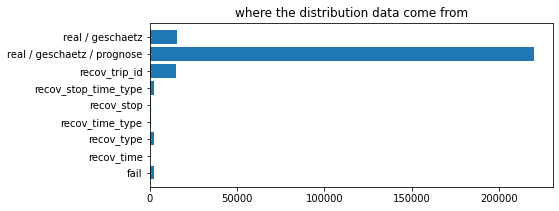

In [224]:
plt.figure(figsize = (8,6))
plt.barh(np.array(['real / geschaetz','real / geschaetz / prognose','recov_trip_id',\
                   'recov_stop_time_type','recov_stop', 'recov_time_type',\
                   'recov_type', 'recov_time', 'fail'])[::-1],\
         np.array([n_real, n_all, n_recov_trip_id, n_recov_stop_time_type, \
                   n_recov_stop_time, n_recov_stop, n_recov_time_type, \
                   n_recov_type, n_recov_time])[::-1])
plt.title('where the distribution data come from')
plt.gcf().subplots_adjust(bottom=0.5, left = 0.2)
plt.savefig("../data/figs/data_final_origin.pdf", dpi=300)
plt.show()

Above plot show where does the final distribution come from. First two lines are data with a perfect match for `trip_id` x `stop_id`. Others show recovery tables used in order of their hierarchy established in last part.

Next we build a summary of results and use `stoptimes` to drive writing of the last table (and make sure we get the right order for our final pre-compute array of probabilities).

In [225]:
summary_df = pd.DataFrame([all_keys, all_hours, all_transport_type, all_distrib],\
                          index = ['key','hour','transport_type','distribution']).transpose()
summary_df.head()

,key,hour,transport_type,distribution
0,2064.TA.26-13-j19-1.24.H__8576240,7,Tram,"[16, 497, 62, 14, 2, 3, 4, 0, 0, 1, 0, 0, 0, 0..."
1,2064.TA.26-13-j19-1.24.H__8591353,7,Tram,"[2, 512, 58, 18, 3, 2, 2, 1, 0, 0, 1, 0, 0, 0,..."
2,2064.TA.26-13-j19-1.24.H__8591039,7,Tram,"[0, 417, 69, 11, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0,..."
3,2064.TA.26-13-j19-1.24.H__8591121,7,Tram,"[0, 405, 80, 12, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,..."
4,2064.TA.26-13-j19-1.24.H__8591417,7,Tram,"[0, 389, 81, 24, 4, 1, 0, 1, 0, 0, 0, 0, 1, 0,..."


 We will now use these in order to reconstruct the final table with $P(T\leq t_i)$ for each time points between -1 and +30, using a cumulative probability function as mentionned above.

In [226]:
list_all_rows = []
for index, row in summary_df.iterrows():
    distrib = np.array(row['distribution'])
    
    # get total number of elements 
    N = np.sum(distrib)
        
    # make cumulative distribution probabilities
    cdf_distrib = np.empty((len(distrib)), dtype=float)
    save_x = 0
    for x in range(len(distrib)):
        cdf_distrib[x] = float(distrib[x])/float(N) + float(save_x)/float(N)
        save_x += distrib[x]
        
    list_all_rows.append(cdf_distrib)

In [227]:
final_df = pd.DataFrame(list_all_rows)
final_df.index = summary_df.index
final_np = final_df.to_numpy()
final_np[0:5,:]

array([[0.0266223 , 0.85357737, 0.95673877, 0.98003328, 0.98336106,
        0.98835275, 0.99500832, 0.99500832, 0.99500832, 0.99667221,
        0.99667221, 0.99667221, 0.99667221, 0.99667221, 0.99667221,
        0.99667221, 0.99667221, 0.99667221, 0.99667221, 0.99667221,
        0.99667221, 0.99667221, 0.99667221, 0.99667221, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.00332779, 0.85524126, 0.95174709, 0.98169717, 0.98668885,
        0.99001664, 0.99334443, 0.99500832, 0.99500832, 0.99500832,
        0.99667221, 0.99667221, 0.99667221, 0.99667221, 0.99667221,
        0.99667221, 0.99667221, 0.99667221, 0.99667221, 0.99667221,
        0.99667221, 0.99667221, 0.99667221, 0.99667221, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.        , 0.82902584, 0.96620278, 0.98807157, 0.99204771,
        0.99204771, 0.99204771, 0.99403579, 0.9940

Last check if all indexes corresponds to `stoptimes` indexes :

In [228]:
sum(np.array(final_df.index == stoptimes.index)) == stoptimes.shape[0]

True

We write the final table, which is the input of McRaptor

In [229]:
################################## WRITE FINAL NUMPY ##################################
with gzip.open("../data/transfer_probabilities.pkl.gz", "wb") as output_file:
    pickle.dump(final_np, output_file)